In [120]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="6";  


import numpy as np
import pandas as pd
import scipy
import os
from sklearn import metrics
from matplotlib import pyplot as plt
import pickle
import h5py
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, precision_recall_curve
from functools import reduce
pd.set_option('max_columns', 999)
pd.set_option('max_rows', 999)
%matplotlib inline


import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import h5py
import os
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
import gc
import h5py

import copy


import pickle
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras import regularizers


from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping


# K.tensorflow_backend._get_available_gpus()

### "split_projids" files:

- train.txt -- all train projids
- test.txt -- all test projids
- CV_splits/x/train.txt -- training projids for CV split x
- CV_splits/x/valid.txt -- validation projids for CV split x

(for now, i saved 5 CV splits so we have 0,1,2,3,4)

### "Data" files:
- Raw/dataset_495_long.csv - longitudinal data (explained in RADC_codebook_data_set_495_10-12-2016.pdf)
- Raw/ROSMAP_clinical.csv - postmortem data, but contains some demographic stuff (explained in ROSMAP_clinical_codebook)
- Processed/merged_data_all.csv - just merged the longitudinal data and pre-mortem demographic variables ("msex", "educ", "apoe_genotype", "race", "spanish")  
- Processed/merged_kept_data.csv - contains only the rows that have labels (currently for rows that have a visit one year earlier AND one year later than the current visit) --- "ONSET_LABEL" = 1 if patient got dementia from current year to next year

Note: ONSET_LABEL depends on two parameters: "predict_ahead" and "require_previous". ONSET_LABEL will only NOT be nan if the current observation is coupled with "require_previous" consecutive observations AND we have a demential label for the current year + predict_ahead's visit. For example, if predict_ahead = 2 and require_previous =3, we will only assign a value to ONSET_LABEL at visit x if we have visits x-1, x-2, and x-3, AND have the dementia label for year x+2. 

The current parameters I used were:
- predict_ahead = 1
- require_previous = 1


If there are no "past" or "change" variables going into the model, can just use "merged_kept_data.csv", which keeps track of only (current vist, label) pairs.  If you want to pass in "past" or "change" variables, need to get those rows from "merged_all_data.csv"

# READING IN DATA

In [109]:
years = 2
within = 3
file_suffix = "%iyrprev_within%i"%(years,within)
with h5py.File("temp_new_filled_%s_LSTMdata.h5"%file_suffix, 'r') as hf:
    ALL_FEATURES_TIME = hf["features"][:]
    ALL_SAMPLES = hf["samples"][:]
DATA = pd.read_csv("DATA/PROCESSED/standardized/merged_kept_data_new_%s.csv"%file_suffix, index_col=0)
feature_names = DATA.columns[7:]
ALL_SAMPLES_df = pd.DataFrame(ALL_SAMPLES, columns=["projid","fu_year","ONSET_LABEL","onset_label_time","onset_label_time_binary"])

In [110]:
encode_method = "all"

In [169]:

simplify_apoe = True
demographic_cols_allyears = ['dcfdx__1.0','dcfdx__2.0', 'dcfdx__3.0', 'med_con_sum_cum', 'vasc_3dis_sum',
                            'vasc_risks_sum', 'hypertension_cum', 'cancer_cum', 'diabetes_sr_rx', 'dm_cum',
                            'headinjrloc_cum', 'thyroid_cum', 'claudication_cum', 'heart_cum', 'stroke_cum']
demographic_cols_oneyear = ['apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0', 'apoe_genotype__33.0', 
                            'apoe_genotype__34.0', 'apoe_genotype__44.0', 'race__1.0', 'race__2.0', 'race__3.0', 
                            'race__6.0', 'age_at_visit', 'educ', 'msex', 'spanish']

baseline_demographics_cols = ['age_at_visit', 'educ', 'msex', 'apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0',
                              'apoe_genotype__33.0', 'apoe_genotype__34.0', 'apoe_genotype__44.0']
baseline_mci_cols = ['dcfdx__2.0', 'dcfdx__3.0']
baseline_mmse30_cols = ['age_at_visit', 'educ', 'msex', 'apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0',
                        'apoe_genotype__33.0', 'apoe_genotype__34.0', 'apoe_genotype__44.0', 'cts_mmse30']
simplified_cols = ['age_at_visit', 'educ', 'msex', 'apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0',
                   'apoe_genotype__33.0', 'apoe_genotype__34.0', 'apoe_genotype__44.0', 
                   'cts_catflu', 'cts_mmse30', 'cts_sdmt', 'cts_wli', 'cts_wlii', 'cts_wliii']
nocogn_cols = ['age_at_visit', 'educ', 'msex', 'apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0',
            'apoe_genotype__33.0', 'apoe_genotype__34.0', 'apoe_genotype__44.0', 'spanish', 
            'race__1.0', 'race__2.0', 'race__3.0', 'race__6.0', 'dcfdx__1.0', 'dcfdx__2.0',  'dcfdx__3.0', 
            'med_con_sum_cum', 'vasc_3dis_sum', 'vasc_risks_sum', 'hypertension_cum', 'cancer_cum', 'diabetes_sr_rx', 
            'dm_cum', 'headinjrloc_cum', 'thyroid_cum', 'claudication_cum', 'heart_cum', 'stroke_cum',
            'cts_animals', 'cts_bname', 'cts_catflu', 'cts_db', 'cts_delay', 'cts_df', 'cts_doperf', 'cts_ebdr', 'cts_ebmt', 
            'cts_fruits', 'cts_idea', 'cts_lopair', 'cts_mmse30', 'cts_nccrtd', 'cts_pmat', 'cts_pmsub', 'cts_read_nart', 
            'cts_sdmt', 'cts_story', 'cts_stroop_cname', 'cts_stroop_wread', 'cts_wli', 'cts_wlii', 'cts_wliii']
all_cols = ['age_at_visit', 'educ', 'msex', 'apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0',
            'apoe_genotype__33.0', 'apoe_genotype__34.0', 'apoe_genotype__44.0', 'spanish', 
            'race__1.0', 'race__2.0', 'race__3.0', 'race__6.0', 'dcfdx__1.0', 'dcfdx__2.0',  'dcfdx__3.0', 
            'med_con_sum_cum', 'vasc_3dis_sum', 'vasc_risks_sum', 'hypertension_cum', 'cancer_cum', 'diabetes_sr_rx', 
            'dm_cum', 'headinjrloc_cum', 'thyroid_cum', 'claudication_cum', 'heart_cum', 'stroke_cum',
            'cts_animals', 'cts_bname', 'cts_catflu', 'cts_db', 'cts_delay', 'cts_df', 'cts_doperf', 'cts_ebdr', 'cts_ebmt', 
            'cts_fruits', 'cts_idea', 'cts_lopair', 'cts_mmse30', 'cts_nccrtd', 'cts_pmat', 'cts_pmsub', 'cts_read_nart', 
            'cts_sdmt', 'cts_story', 'cts_stroop_cname', 'cts_stroop_wread', 'cts_wli', 'cts_wlii', 'cts_wliii',
            'cogn_ep', 'cogn_po', 'cogn_ps', 'cogn_se', 'cogn_wo', 'cogn_global']

# Change depending on which test you want to run
cols_to_use = nocogn_cols
cols_name = 'nocogn_cols'

In [170]:
ALL_FEATURES_TIME_dfs = [pd.DataFrame(ALL_FEATURES_TIME[:,x,:], columns=feature_names)[cols_to_use] for x in range(ALL_FEATURES_TIME.shape[1])]
model_data_dfs = copy.copy(ALL_FEATURES_TIME_dfs)

for t,df in enumerate(model_data_dfs):
    if simplify_apoe and ('apoe_genotype__44.0' in cols_to_use):
        apoe_cols = ['apoe_genotype__22.0', 'apoe_genotype__23.0', 'apoe_genotype__24.0', 'apoe_genotype__33.0', 'apoe_genotype__34.0']
        for c in apoe_cols:
            if c not in df.columns:
                df[c] = 0
        df['apoe4_1copy'] = df['apoe_genotype__24.0'] + df['apoe_genotype__34.0']
        df.rename(columns={'apoe_genotype__44.0': 'apoe4_2copies'}, inplace=True)
        df.drop(labels=apoe_cols, axis=1, inplace=True)


    if cols_name == 'baseline_mci_cols':
        df['mci'] = df['dcfdx__2.0'] + df['dcfdx__3.0']
        df.drop(labels=['dcfdx__2.0', 'dcfdx__3.0'], axis=1, inplace=True)
    
    for col in df.columns.values:
        df[col] = pd.to_numeric(df[col])
        

In [171]:
selected_features = model_data_dfs[0].columns
data_selected_features = np.hstack([x.values for x in model_data_dfs]).reshape(ALL_FEATURES_TIME.shape[0], ALL_FEATURES_TIME.shape[1], -1)

## Train Models

In [175]:
only_one = True
# this is assuming 0 is current year
single_training_year = -2


sample_type = "train" # randdownsample, matcheddownsample, train, weighted
sample_type_prefix = "" if sample_type in ["train", "weighted"] else "%s_"%sample_type
sample_type_save = "" if sample_type=="train" else "%s_"%sample_type
num_years_data = 3 #this is if we're using cumulative data, how many years to include

if encode_method == 'ema':
    encode_method = encode_method+str(half_life)
if only_one:
    save_suffix = '%s%s_%iyrprev_within%i_singleyear%i'%(sample_type_save, cols_name, years, within, single_training_year)
else:
    save_suffix = '%s%s_%iyrprev_within%i_yrsincluded%i'%(sample_type_save, cols_name, years, within, num_years_data)

## LSTM

class_weights: {0: 1, 1: 1}
(5880, 1, 49)
Epoch 00016: early stopping
[0.887719298245614] [0.8745757765269961] [0.5603125934757647]
saved to: 
./results/CV/LSTM_0_nocogn_cols_2yrprev_within3_singleyear-2.p
class_weights: {0: 1, 1: 1}
(5863, 1, 49)
Epoch 00010: early stopping
[0.8744798890429958] [0.8882821989969572] [0.5541193157896609]
class_weights: {0: 1, 1: 1}
(5847, 1, 49)
Epoch 00014: early stopping
[0.8724279835390947] [0.8711494894163792] [0.5948536972873599]
class_weights: {0: 1, 1: 1}
(5882, 1, 49)
Epoch 00011: early stopping
[0.859451862262825] [0.8516704466856472] [0.46294005403339655]
class_weights: {0: 1, 1: 1}
(5769, 1, 49)
Epoch 00012: early stopping
[0.8723958333333334] [0.864821539568816] [0.5114901381055011]


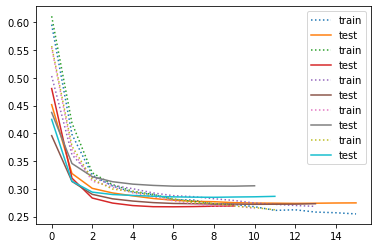

In [177]:
for i in range(5):

    accuracy_save = []
    roc_auc_save = []
    pr_auc_save = []
    precision_save = []
    recall_save = []
    fpr_save = []
    tpr_save = []

    if sample_type in ["matcheddownsample","randdownsample"]:
        train_samples_df = pd.read_csv("split_projids1/CV_splits/%i/%strain_%s.txt"%(i,sample_type_prefix,file_suffix),index_col=0).drop_duplicates()
        train_samples_df["keep"]=1
        data_train = pd.merge(DATA, train_samples_df, on=['projid','fu_year'], how='left')
        train_idx = (data_train["keep"]==1).values
    else:
        train_samples_df= pd.read_csv("split_projids1/CV_splits/%i/%strain_%s.txt"%(i,sample_type_prefix,file_suffix),names=["projid"]).drop_duplicates()
        train_samples_df["keep"]=1
        data_train = pd.merge(DATA, train_samples_df, on=['projid'], how='left')
        train_idx = (data_train["keep"]==1).values
        
    if sample_type == "weighted":
        class_weight = {0: 1., 1: np.sum(label_tr==0)/np.sum(label_tr==1)}
    else:
        class_weight = {0:1, 1:1}
    print("class_weights:", class_weight)
    valid_idx =ALL_SAMPLES_df["projid"].isin(np.loadtxt("split_projids1/CV_splits/%i/valid_%s.txt"%(i,file_suffix))).values

    label_tr = ALL_SAMPLES[train_idx][:,4]
    label_val =ALL_SAMPLES[valid_idx][:,4] 
    
    if only_one:
        data_tr = data_selected_features[train_idx][:,single_training_year-1,:]
        data_val = data_selected_features[valid_idx][:,single_training_year-1,:]

        data_tr = np.reshape(data_tr,(data_tr.shape[0], 1, data_tr.shape[-1]))
        data_val = np.reshape(data_val,(data_val.shape[0], 1, data_val.shape[-1]))
        
    else:
        data_tr = data_selected_features[train_idx][:,-num_years_data:,:]
        data_val = data_selected_features[valid_idx][:,-num_years_data:,:]
    
        data_tr = np.reshape(data_tr,(data_tr.shape[0], num_years_data, data_tr.shape[-1]))
        data_val = np.reshape(data_val,(data_val.shape[0], num_years_data, data_val.shape[-1]))
    
    
    print(data_tr.shape)
     # design network
    model = Sequential()
    
    # kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)
    model.add(LSTM(20, input_shape=(data_tr.shape[1], data_tr.shape[2])))  # returns a sequence of vectors of dimension 32
    
    model.add(Dropout(.1))
    model.add(Dense(5, activation="relu"))
    model.add(Dropout(.1))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    # fit model

    history = model.fit(data_tr, label_tr, epochs=20, batch_size=100, class_weight = class_weight, 
                        validation_data=(data_val, label_val), verbose=0, shuffle=False,  callbacks=[es])
    
    # plot history
    pyplot.plot(history.history['loss'], label='train', linestyle=":")
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    
    predr = model.predict(data_val)
    accuracy_save.append(metrics.accuracy_score(label_val,np.round(predr)))
    fpr, tpr, _ = metrics.roc_curve(label_val,predr)
    fpr_save = fpr
    tpr_save = tpr
    roc_auc_save.append(metrics.auc(fpr,tpr))
    precision, recall, _ = metrics.precision_recall_curve(label_val,predr)
    precision_save.append(precision)
    recall_save.append(recall)
    pr_auc_save.append(metrics.auc(recall, precision))
    new_results = [accuracy_save,roc_auc_save,pr_auc_save,precision_save,recall_save,fpr_save,tpr_save]
    print(accuracy_save,roc_auc_save,pr_auc_save)

    pickle.dump(new_results, open('./results/CV/LSTM_%i_%s.p'%(i,save_suffix), 'wb'))
    if i==0:
        print("saved to: ")
        print('./results/CV/LSTM_%i_%s.p'%(i,save_suffix))
    K.clear_session()
    gc.collect()

##  MLP

class_weights: {0: 1, 1: 1}
[0.9066666666666666] [0.9161121534292266] [0.6697911794746558]
saved to: 
./results/CV/MLP_0_nocogn_cols_2yrprev_within3_yrsincluded3.p
class_weights: {0: 1, 1: 1}
[0.9022191400832178] [0.9307291102906099] [0.6513017921037387]
class_weights: {0: 1, 1: 1}
[0.9224965706447188] [0.9296637248934876] [0.7216952649204944]
class_weights: {0: 1, 1: 1}
[0.8882642304989459] [0.9068949154723416] [0.6673760732879374]
class_weights: {0: 1, 1: 1}
[0.8984375] [0.9096156712213245] [0.636860388209197]


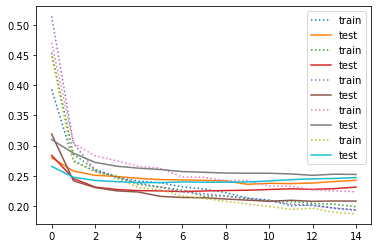

In [115]:
for i in range(5):

    accuracy_save = []
    roc_auc_save = []
    pr_auc_save = []
    precision_save = []
    recall_save = []
    fpr_save = []
    tpr_save = []

    if sample_type in ["matcheddownsample","randdownsample"]:
        train_samples_df = pd.read_csv("split_projids1/CV_splits/%i/%strain_%s.txt"%(i,sample_type_prefix,file_suffix),index_col=0).drop_duplicates()
        train_samples_df["keep"]=1
        data_train = pd.merge(DATA, train_samples_df, on=['projid','fu_year'], how='left')
        train_idx = (data_train["keep"]==1).values
    else:
        train_samples_df= pd.read_csv("split_projids1/CV_splits/%i/%strain_%s.txt"%(i,sample_type_prefix,file_suffix),names=["projid"]).drop_duplicates()
        train_samples_df["keep"]=1
        data_train = pd.merge(DATA, train_samples_df, on=['projid'], how='left')
        train_idx = (data_train["keep"]==1).values
        
    if sample_type == "weighted":
        class_weight = {0: 1., 1: np.sum(label_tr==0)/np.sum(label_tr==1)}
    else:
        class_weight = {0:1, 1:1}
    print("class_weights:", class_weight)
    valid_idx =ALL_SAMPLES_df["projid"].isin(np.loadtxt("split_projids1/CV_splits/%i/valid_%s.txt"%(i,file_suffix))).values
    
    
    label_tr = ALL_SAMPLES[train_idx][:,4]
    label_val =ALL_SAMPLES[valid_idx][:,4] 
    data_tr = data_selected_features[train_idx][:,-num_years_data:,:].reshape(sum(train_idx),-1)
    data_val = data_selected_features[valid_idx][:,-num_years_data:,:].reshape(sum(valid_idx),-1)
    

    # design network
    model = Sequential()
    
    model.add(Dense(30, activation="relu"))
    model.add(Dropout(.1))
    model.add(Dense(5, activation="relu"))
    model.add(Dropout(.1))
  
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit network
    history = model.fit(data_tr, label_tr, epochs=15, batch_size=100, class_weight = class_weight, validation_data=(data_val, label_val), verbose=0, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train', linestyle=":")
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    

    
    predr = model.predict(data_val)
    accuracy_save.append(metrics.accuracy_score(label_val,np.round(predr)))
    fpr, tpr, _ = metrics.roc_curve(label_val,predr)
    fpr_save = fpr
    tpr_save = tpr
    roc_auc_save.append(metrics.auc(fpr,tpr))
    precision, recall, _ = metrics.precision_recall_curve(label_val,predr)
    precision_save.append(precision)
    recall_save.append(recall)
    pr_auc_save.append(metrics.auc(recall, precision))
    new_results = [accuracy_save,roc_auc_save,pr_auc_save,precision_save,recall_save,fpr_save,tpr_save]
    print(accuracy_save,roc_auc_save,pr_auc_save)

    pickle.dump(new_results, open('./results/CV/MLP_%i_%s.p'%(i,save_suffix), 'wb'))
#     pickle.dump(model, open('./results/CV/models/MLP_%i_%s.dat'%(i,save_suffix), "wb"))
    
    if i==0:
        print("saved to: ")
        print('./results/CV/MLP_%i_%s.p'%(i,save_suffix))

    K.clear_session()
    gc.collect()